# SIC Curve Analysis Notebook

A streamlined version with clear sections and helper functions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# Add these:
from tensorflow.keras.layers import Dense, Flatten, Dropout

# GPU configuration
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
strategy = tf.distribute.MirroredStrategy()


2025-04-29 18:34:41.453175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 18:34:41.453206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 18:34:41.542546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 18:34:41.674596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 18:34:46.965505: W tensorflow/compiler/tf2

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-04-29 18:35:07.192334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-04-29 18:35:07.194978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-04-29 18:35:07.196763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2025-04-29 18:35:07.199812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [2]:
# ===== Helper Functions =====
def load_data(path, key, scale_to_tev=True):
    return load_m_mx_my_tau12_tau23(path, key=key, scale_to_tev=scale_to_tev)

def prepare_inputs(df):
    X = df[['mj1','tau12j1','tau23j1','mj2','tau12j2','tau23j2']].values.reshape(-1,2,3)
    y = df['label'].astype(np.float32).values
    return X, y

def build_callbacks(key):
    os.makedirs('models', exist_ok=True)
    return [
        tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f'models/best_{key}.h5',
                                           'val_loss', save_best_only=True)
    ]

def compute_sic(y_true, y_pred, fpr_min=1e-3):
    """
    Compute TPR vs. SIC = TPR / sqrt(FPR), but floor FPR to fpr_min
    to avoid enormous ratios when FPR is tiny.
    Returns (tpr, sic).
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred, drop_intermediate=True)
    # floor FPR
    denom = np.sqrt(np.maximum(fpr, fpr_min))
    sic = tpr / denom
    # clean up NaNs/Infs
    sic = np.nan_to_num(sic, nan=0.0, posinf=0.0, neginf=0.0)
    return tpr, sic

def plot_sic_curves(results, title):
    plt.figure(figsize=(8,6))
    for label, tpr, sic in results:
        plt.plot(tpr, sic, label=label)
    plt.title(title)
    plt.xlabel('Signal Efficiency (TPR)')
    plt.ylabel('SIC (TPR / √max(FPR,fpr_min))')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3]:
###############################################################################
# 2. Load from HDF5: ensures m, mx, my, tau12, tau23, label exist
###############################################################################
def load_m_mx_my_tau12_tau23(
    file_path: str,
    key: str = "/df",
    scale_to_tev: bool = False,
    assign_label: int = None
) -> pd.DataFrame:
    """
    Reads HDF5 (file_path) under group 'key' into a DataFrame.
    - If 'assign_label' is an integer, sets 'label' to that.
    - If 'scale_to_tev' is True, multiply masses by 0.001.
    - Ensures columns: mj1, mj2, tau12j1, tau23j1, tau12j2, tau23j2, mx, my, label.
    """
    df = pd.read_hdf(file_path, key=key)

    # Assign label 
    if assign_label is not None:
        df["label"] = assign_label

    # scale from GeV to TeV
    scale = 0.001 if scale_to_tev else 1.0

    for j in ["j1", "j2"]:
        mcol = f"m{j}"
        if mcol not in df.columns:
            df[mcol] = 0.0
        df[mcol] *= scale

        for base in ["tau1", "tau2", "tau3"]:
            if f"{base}{j}" not in df.columns:
                df[f"{base}{j}"] = 0.0

        tau1 = df[f"tau1{j}"]
        tau2 = df[f"tau2{j}"]
        tau3 = df[f"tau3{j}"]
        mask_12 = (tau1 > 0) & (tau2 > 0)
        mask_23 = (tau2 > 0) & (tau3 > 0)
        df[f"tau12{j}"] = np.where(mask_12, tau2 / tau1, 0.0)
        df[f"tau23{j}"] = np.where(mask_23, tau3 / tau2, 0.0)

    if "mx" not in df.columns:
        df["mx"] = 0.0
    if "my" not in df.columns:
        df["my"] = 0.0

    needed_cols = [
        "mj1", "tau12j1", "tau23j1",
        "mj2", "tau12j2", "tau23j2",
        "mx", "my"
    ]
    if "label" in df.columns:
        needed_cols.append("label")

    
    for c in needed_cols:
        if c not in df.columns:
            df[c] = 0.0

    return df[needed_cols].copy()

In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from aliad.interface.tensorflow.losses import ScaledBinaryCrossentropy  
import numpy as np

def base_highlevel_model(name="BaseModel", input_name="input_features", input_shape=(2, 3), use_scaled_bce=False):
    inputs = Input(shape=input_shape, name=input_name)
    x = Flatten()(inputs)

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name=name)

    if use_scaled_bce:
        loss_fn = ScaledBinaryCrossentropy(offset=-np.log(2), scale=1000)
    else:
        loss_fn = "binary_crossentropy"

    model.compile(optimizer=Adam(learning_rate=1e-3), loss=loss_fn, metrics=["accuracy"])
    return model

def simple_supervised_model():
    return base_highlevel_model(name="SimpleSupervisedModel", input_name="input_features", use_scaled_bce=False)

def ideal_weakly_supervised_model():
    return base_highlevel_model(name="IdealWeaklySupervisedModel", input_name="ideal_weakly_input", use_scaled_bce=True)



In [5]:
from sklearn.model_selection import train_test_split

# ===== Data Preparation (DataFrame splits) =====
# 1) Load and label
paths = {
    'qcd':   ("/global/cfs/projectdirs/m3246/alkaid/paws/datasets/original/"
              "events_anomalydetection_v2.features.h5", "/df"),
    'extra': ("/global/cfs/projectdirs/m3246/alkaid/paws/datasets/original/"
              "events_anomalydetection_qcd_extra_inneronly_features.h5", "/df"),
    'signal':("/global/cfs/projectdirs/m3246/alkaid/paws/datasets/original/"
              "events_anomalydetection_Z_XY_qq_parametric.h5", "/output")
}
dfs = {k: load_data(path, key) for k,(path,key) in paths.items()}
dfs['qcd']['label']    = 0
dfs['extra']['label']  = 0
dfs['signal']['label'] = 1

# 2) Split background into train/val/test (70/15/15)
df_bkg = pd.concat([dfs['qcd'], dfs['extra']], ignore_index=True)
df_bkg_train_val, df_bkg_test = train_test_split(df_bkg, test_size=0.15, random_state=42)
df_bkg_train,     df_bkg_val  = train_test_split(
    df_bkg_train_val, test_size=0.15/0.85, random_state=42
)

# 3) Split each signal mass‐point the same way
signal_groups = {
    (300,300): dfs['signal'].query("mx==300 and my==300"),
    (100,500): dfs['signal'].query("mx==100 and my==500"),
    (500,100): dfs['signal'].query("mx==500 and my==100")
}
signals_train = {}
signals_val   = {}
signals_test  = {}
for mp, df_sig in signal_groups.items():
    trval, test = train_test_split(df_sig,   test_size=0.15, random_state=42)
    train, val  = train_test_split(trval,    test_size=0.15/0.85, random_state=42)
    # reset indices so masking/dropping works cleanly
    signals_train[mp] = train.reset_index(drop=True)
    signals_val[mp]   = val.reset_index(drop=True)
    signals_test[mp]  = test.reset_index(drop=True)

# 4) Build testsets for evaluation
testsets = {
    mp: pd.concat([df_bkg_test, signals_test[mp]], ignore_index=True)
    for mp in signal_groups
}




In [6]:
def train_models():
    models = {}

    # ---- Generalist supervised ----
    # 1) Stack all train+val signals into one DataFrame
    df_all_train = pd.concat(signals_train.values(), ignore_index=True)
    df_all_val   = pd.concat(signals_val.values(),   ignore_index=True)
    sig_train_all = pd.concat([df_all_train, df_all_val], ignore_index=True)

    # 2) Exclude specialist mass points (300,300), (100,500), (500,100)
    mask_general = ~(
        ((sig_train_all['mx'] == 300) & (sig_train_all['my'] == 300)) |
        ((sig_train_all['mx'] == 100) & (sig_train_all['my'] == 500)) |
        ((sig_train_all['mx'] == 500) & (sig_train_all['my'] == 100))
    )
    df_gen = pd.concat([sig_train_all[mask_general], df_bkg_train],
                       ignore_index=True)

    # 3) Train generalist supervised model
    Xg, yg = prepare_inputs(df_gen)
    Xg_tr, Xg_val, yg_tr, yg_val = train_test_split(
        Xg, yg, test_size=0.2, random_state=42
    )
    with strategy.scope():
        m_gen = simple_supervised_model()
        m_gen.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    m_gen.fit(
        Xg_tr, yg_tr,
        validation_data=(Xg_val, yg_val),
        epochs=10, batch_size=512, verbose=0
    )
    models['gen'] = m_gen

    # ---- Specialist supervised & Weakly supervised ----
    for (mx, my), sig_train in signals_train.items():
        # Build key strings once
        key_sup  = f"sup_{mx}_{my}"
        
        # -- 1) Supervised specialist --
        df_sup = pd.concat([sig_train, df_bkg_train], ignore_index=True)
        Xs, ys = prepare_inputs(df_sup)
        Xs_tr, Xs_val, ys_tr, ys_val = train_test_split(
            Xs, ys, test_size=0.2, random_state=42
        )
        with strategy.scope():
            m_sup = simple_supervised_model()
            m_sup.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
        m_sup.fit(
            Xs_tr, ys_tr,
            validation_data=(Xs_val, ys_val),
            epochs=10, batch_size=512, verbose=0
        )
        models[key_sup] = m_sup

        # -- 2) Weakly supervised for each injection level --
        for mu in injection_levels:
            key_weak = f"weak_{mx}_{my}_{mu:.3f}"
            seed = int(mu * 1e6) % 10000
            df_bg = df_bkg_train.sample(frac=1.0, random_state=seed) \
                               .reset_index(drop=True)
            half = len(df_bg) // 2

            # R: pure background half
            R    = df_bg.iloc[:half].copy()
            # D_bg: background half for mixture
            D_bg = df_bg.iloc[half:].copy()
            # D_sig: true signals injected from sig_train
            n_sig = int(len(D_bg) * mu)
            D_sig = sig_train.sample(n=n_sig, random_state=42)

            # Build mixture D = D_bg + D_sig
            D = pd.concat([D_bg, D_sig], ignore_index=True)

            # Label for CWoLa training
            R['label'] = 0
            D['label'] = 1
            df_w = pd.concat([R, D], ignore_index=True) \
                     .sample(frac=1.0, random_state=42)

            # Print mixture composition
            print(f"Weakly μ={mu:.3f}: "
                  f"R_only={len(R)}, D_bg={len(D_bg)}, D_sig={len(D_sig)}")

            # Train weakly supervised model
            Xw, yw = prepare_inputs(df_w)
            with strategy.scope():
                m_w = ideal_weakly_supervised_model()
                m_w.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])
            m_w.fit(
                Xw, yw,
                validation_split=0.2,
                epochs=10, batch_size=512, verbose=0
            )
            models[key_weak] = m_w

    return models


INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task

2025-04-29 18:35:25.923168: I external/local_xla/xla/service/service.cc:168] XLA service 0x7feb65d99860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-29 18:35:25.923197: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-29 18:35:25.923207: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-29 18:35:25.923210: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-29 18:35:25.923213: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-29 18:35:25.933508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-29 18:3

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
Weakly μ=0.001: R_only=599500, D_bg=599500, D_sig=599
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 8 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
Weakly μ=0.002: R_only=599

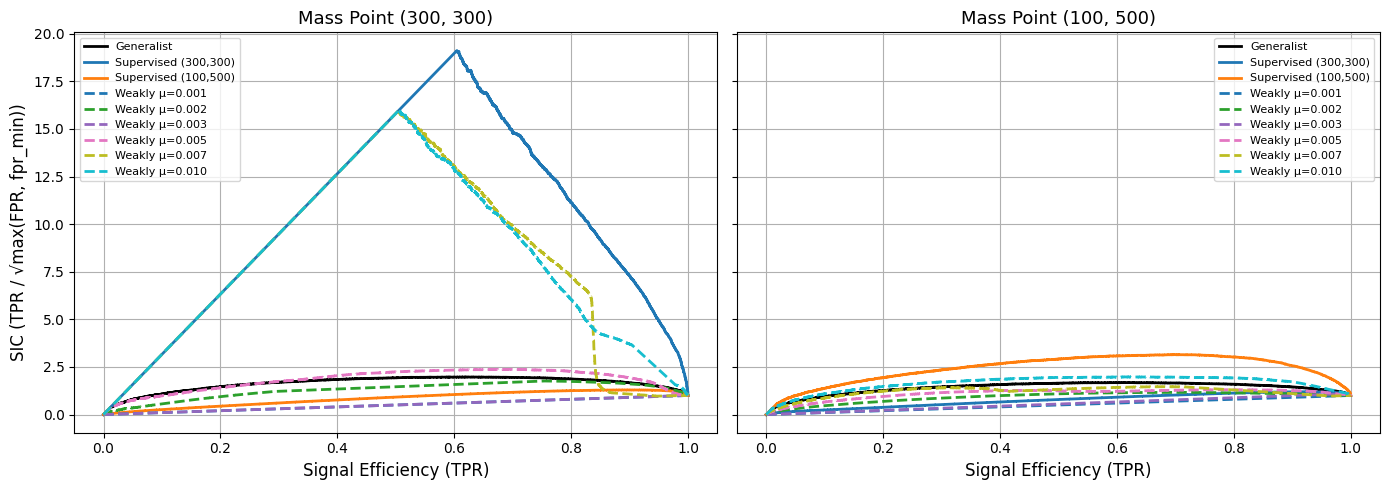

In [7]:
# ===== Configuration =====
injection_levels = [0.001, 0.002, 0.003, 0.005, 0.007, 0.010]

# ===== Imports =====
from matplotlib import colormaps
import matplotlib.pyplot as plt

# ===== Prepare injection colors =====
cmap = colormaps['tab10'].resampled(len(injection_levels))
injection_colors = {mu: cmap(i) for i, mu in enumerate(injection_levels)}

# ===== Plot helper =====
def plot_sic_on_ax(ax, name, tpr, sic, color, linestyle):
    ax.plot(tpr, sic, label=name, color=color, linestyle=linestyle, linewidth=2)

# ===== Main plotting routine =====
def main():
    models = train_models()
    mass_points = [(300, 300), (100, 500)]

    fig, axs = plt.subplots(1, len(mass_points), figsize=(14, 5), sharey=True)
    for ax, (mx, my) in zip(axs, mass_points):
        # Prepare the test data
        X_test, y_test = prepare_inputs(testsets[(mx, my)])

        # 1) Generalist supervised
        tpr, sic = compute_sic(
            y_test,
            models['gen'].predict(X_test, batch_size=512).flatten()
        )
        plot_sic_on_ax(ax, 'Generalist', tpr, sic, 'black', '-')

        # 2) Specialist supervised (both mass points)
        for spec_key, color in [('sup_300_300', 'tab:blue'),
                                ('sup_100_500', 'tab:orange')]:
            tpr, sic = compute_sic(
                y_test,
                models[spec_key].predict(X_test, batch_size=512).flatten()
            )
            mp_label = spec_key.split('_', 1)[1].replace('_', ',')
            plot_sic_on_ax(ax,
                           f"Supervised ({mp_label})",
                           tpr, sic,
                           color, '-')

        # 3) Weakly supervised at each μ
        for mu in injection_levels:
            wkey = f"weak_{mx}_{my}_{mu:.3f}"
            tpr, sic = compute_sic(
                y_test,
                models[wkey].predict(X_test, batch_size=512).flatten()
            )
            plot_sic_on_ax(ax,
                           f"Weakly μ={mu:.3f}",
                           tpr, sic,
                           injection_colors[mu], '--')

        # Formatting
        ax.set_title(f"Mass Point ({mx}, {my})", fontsize=13)
        ax.set_xlabel("Signal Efficiency (TPR)", fontsize=12)
        if (mx, my) == mass_points[0]:
            ax.set_ylabel("SIC (TPR / √max(FPR, fpr_min))", fontsize=12)
        ax.legend(fontsize=8)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
